In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

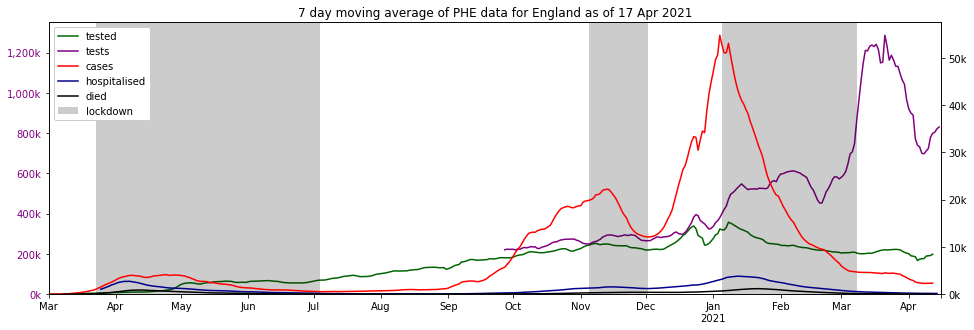

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

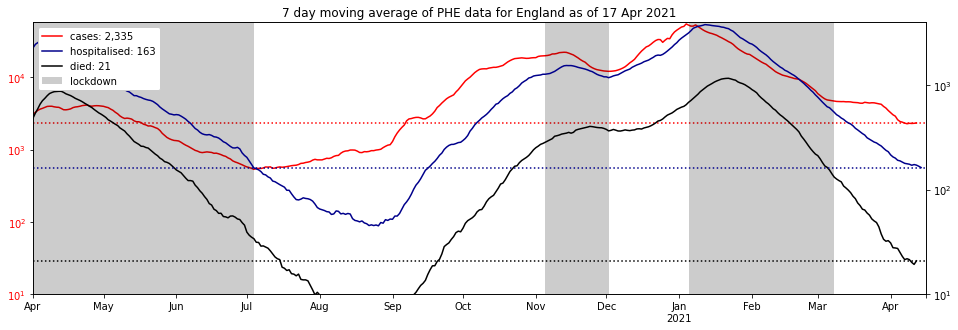

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

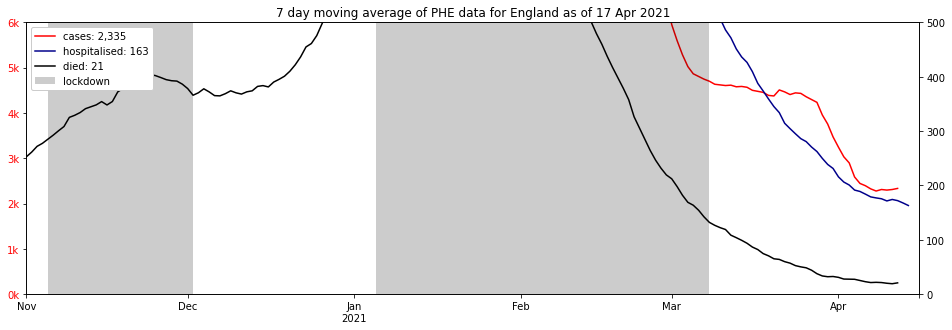

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

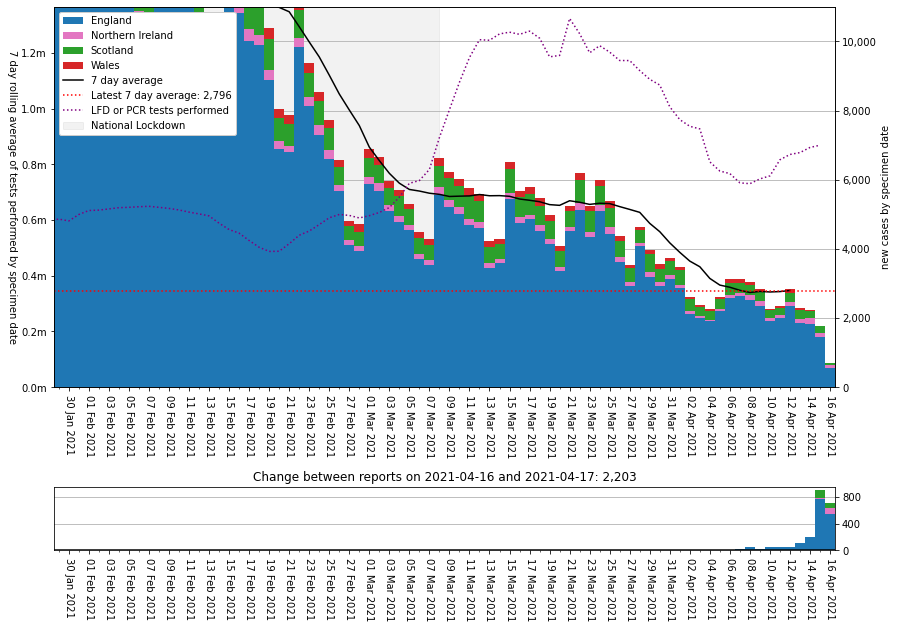

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

In [6]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,16 Apr 21,"+7,863,747","+27,447,286","+7,863,747","+446,025","+102,280","+446,025"
Northern Ireland,16 Apr 21,"+262,917","+855,826","+262,917","+12,443","+5,723","+12,443"
Scotland,16 Apr 21,"+715,714","+2,733,387","+715,714","+26,953","+11,303","+26,953"
Wales,16 Apr 21,"+574,590","+1,657,028","+574,590",+0,+0,+0


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,7863747.0,27447286.0,19583539.0,56286961,13.970815,34.792319,51.236866
1,Northern Ireland,N92000002,262917.0,855826.0,592909.0,1893667,13.884014,31.310098,54.805887
2,Scotland,S92000003,715714.0,2733387.0,2017673.0,5463300,13.100397,36.931397,49.968206
3,Wales,W92000004,574590.0,1657028.0,1082438.0,3152879,18.224296,34.331733,47.443971


'partial: 32,693,527 (48.9%), full: 9,416,968'

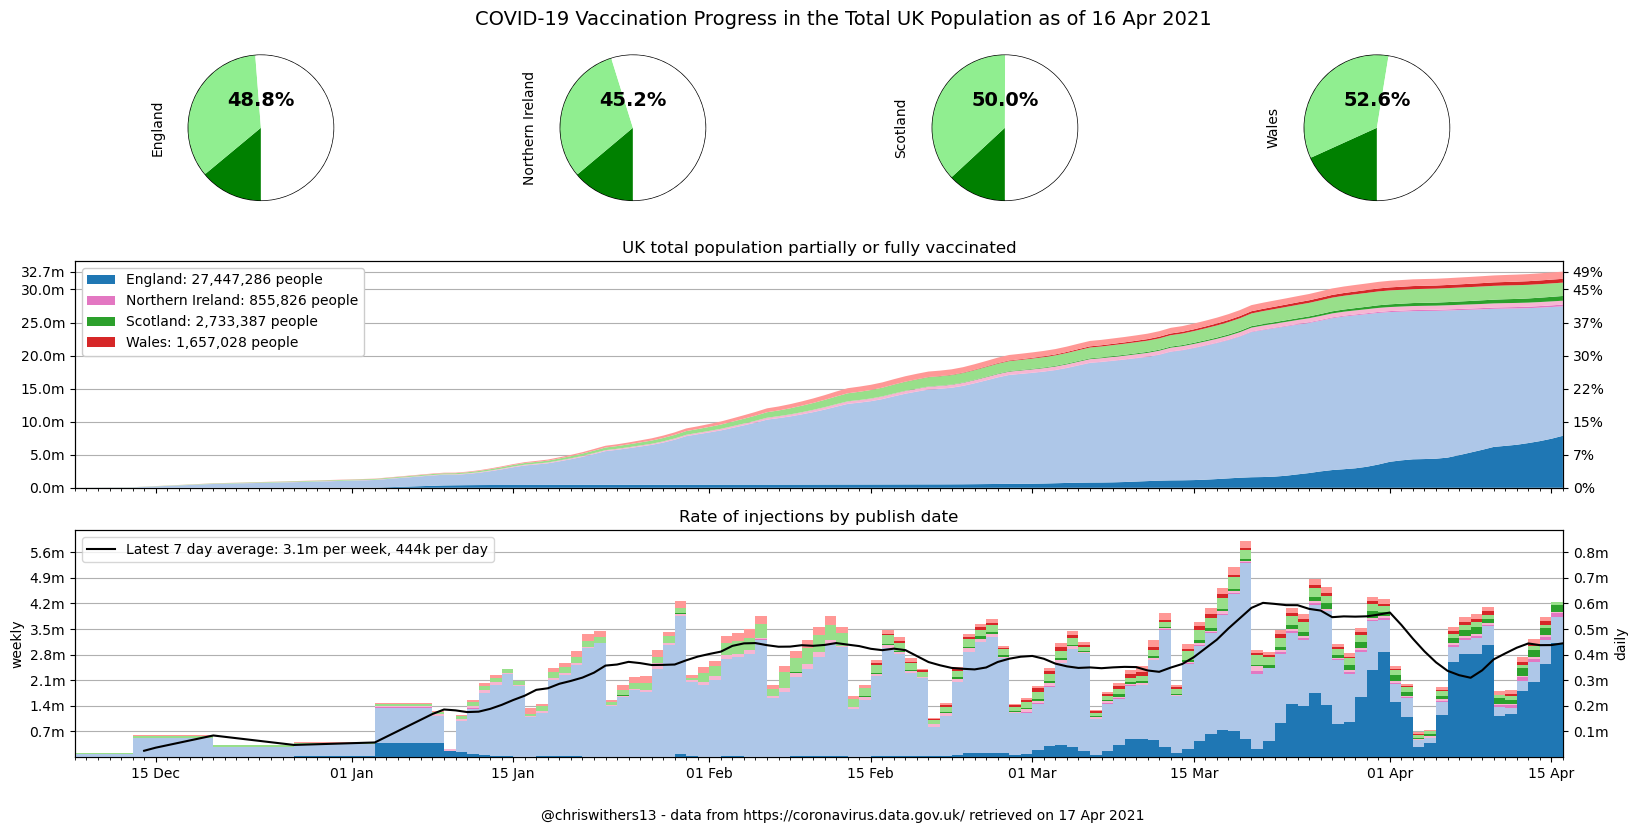

In [7]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

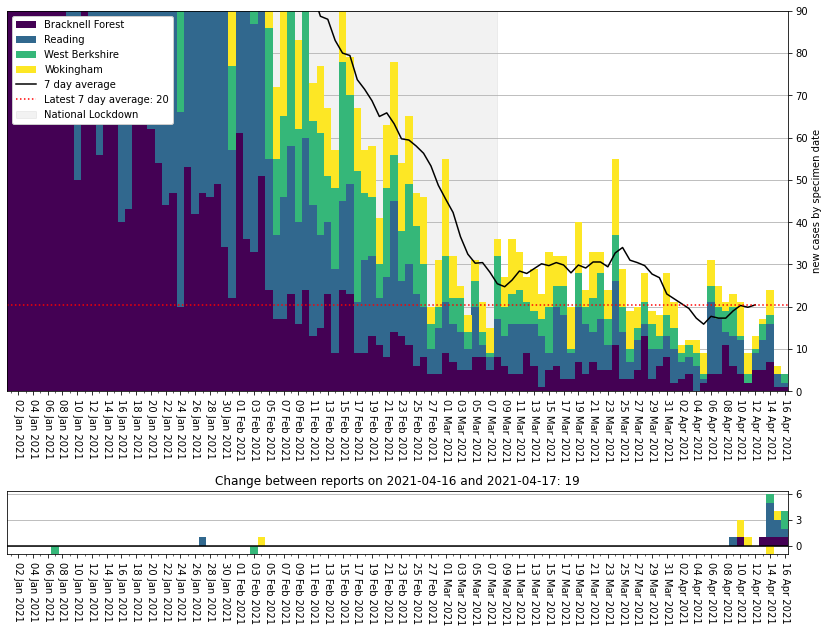

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

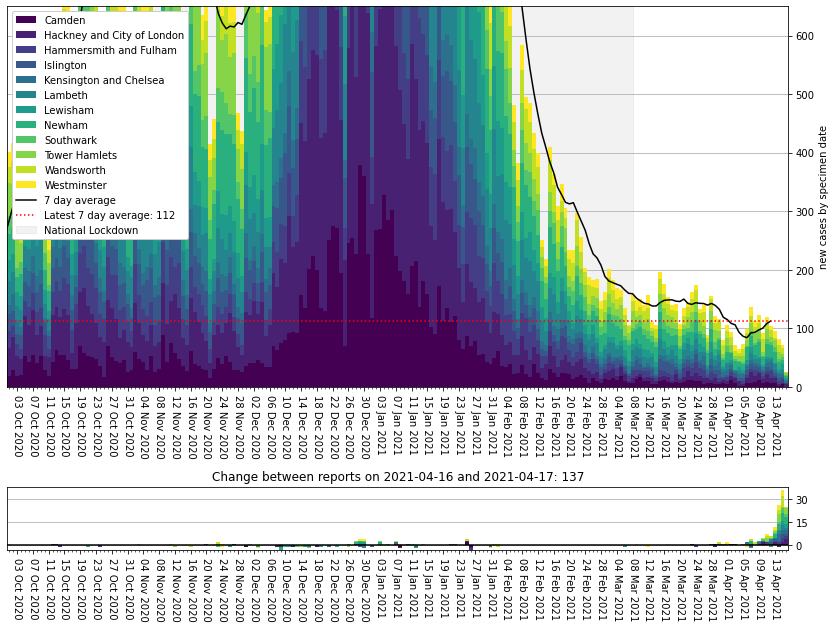

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
N09000005,Derry City and Strabane,107.083366,162.0,2021-04-16
E06000032,Luton,73.690930,157.0,2021-04-16
E08000017,Doncaster,68.293309,213.0,2021-04-16
E08000016,Barnsley,60.761709,150.0,2021-04-16
E08000032,Bradford,60.395423,326.0,2021-04-16
E06000010,"Kingston upon Hull, City of",58.126554,151.0,2021-04-16
N09000009,Mid Ulster,57.228267,85.0,2021-04-16
E07000156,Wellingborough,56.456773,45.0,2021-04-16
S12000005,Clackmannanshire,56.266977,29.0,2021-04-16


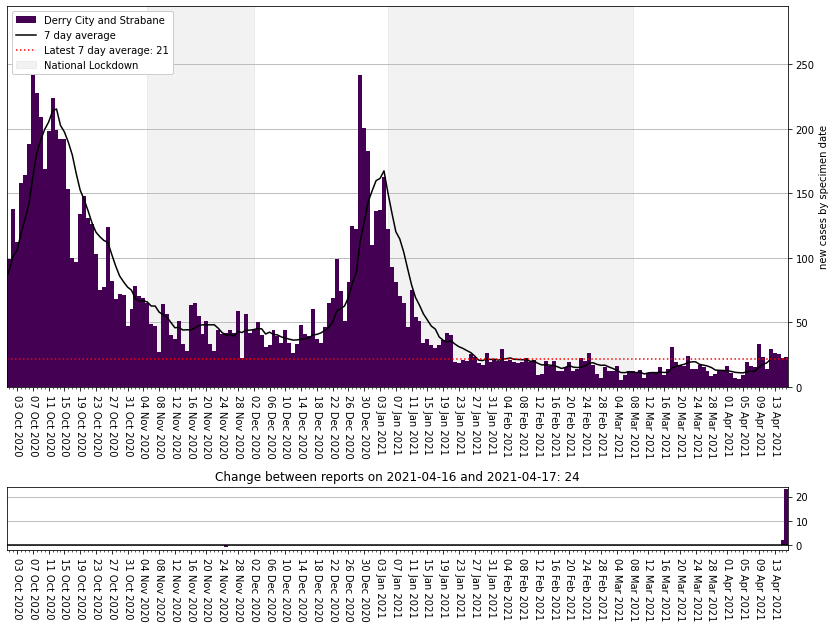

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000049,Glasgow City,51.964872,329.0,2021-04-16
E08000032,Bradford,60.395423,326.0,2021-04-16
E08000035,Leeds,37.950473,301.0,2021-04-16
E08000019,Sheffield,42.574801,249.0,2021-04-16
E08000034,Kirklees,52.525427,231.0,2021-04-16
E08000025,Birmingham,20.055771,229.0,2021-04-16
E08000017,Doncaster,68.293309,213.0,2021-04-16
E08000003,Manchester,38.346194,212.0,2021-04-16
E06000016,Leicester,55.896834,198.0,2021-04-16


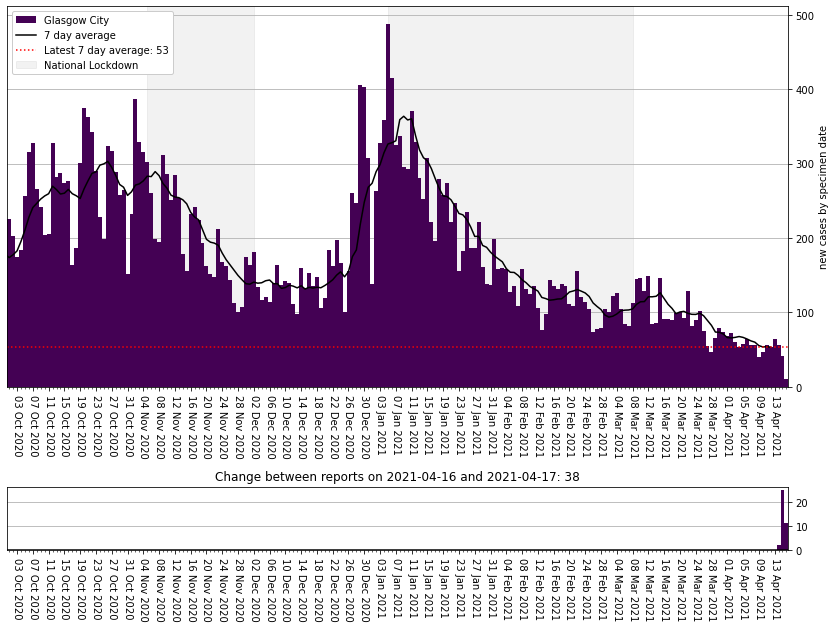

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.13

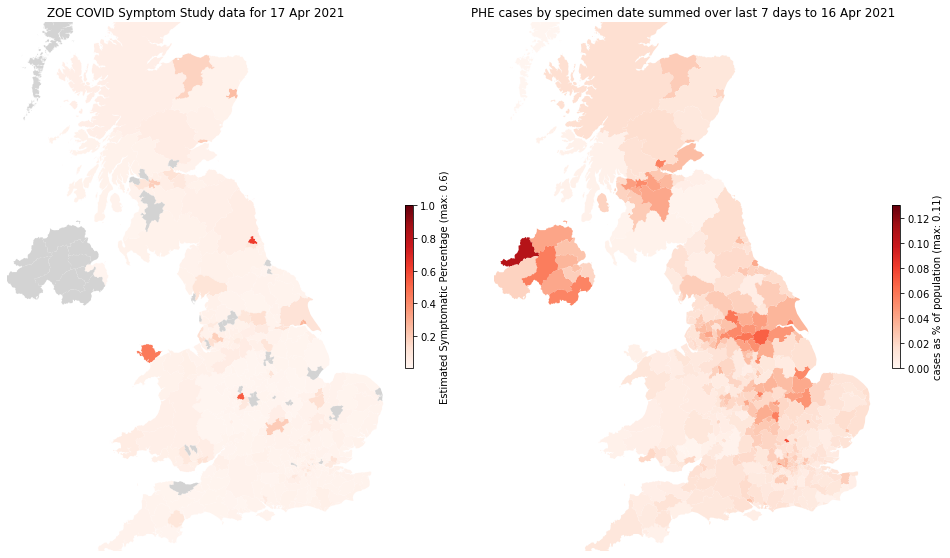

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...